## Analytical

## Training

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import numpy as np
import ot # Python Optimal Transport library
import functools # For passing arguments to collate_fn

import sys
sys.path.append('/Users/adamsobieszek/PycharmProjects/manipy/levelset_fm')
from models.flow_model import VectorFieldTransformer, VectorFieldModel2
from lamb_optimizer import Lamb


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps")
DTYPE = torch.float32

class PoolDataset(Dataset):
    """
    A dataset that holds a pre-sampled pool of points.
    During initialization, it samples points such that the distribution of their
    f(x) values is approximately uniform.
    Used with a custom collate_fn for dynamic minibatch OT pairing.
    """
    def __init__(self,
                 distribution,    # PyTorch distribution to sample P_X from
                 f_func,          # Function f(x) -> scalar
                 pool_size=10000, # Desired final size of the pool
                 oversample_factor=10, # How many times more samples to draw initially
                 num_f_bins=100,    # Number of bins for f-value histogram re-weighting
                 device=None,
                 dtype=None):

        self.distribution = distribution
        self.f_func = f_func
        self.pool_size = pool_size
        self.oversample_factor = oversample_factor
        self.num_f_bins = num_f_bins
        self.device = device if device is not None else torch.device("cpu")
        self.dtype = dtype if dtype is not None else torch.float32

        print(f"Initializing PoolDataset on {self.device} with {self.dtype}.")
        print(f"Target pool size: {self.pool_size}. Oversampling factor: {self.oversample_factor}.")

        with torch.no_grad():
            # 1. Oversample initially
            num_initial_samples = self.pool_size * self.oversample_factor
            print(f"Generating initial {num_initial_samples} samples from the distribution...")
            initial_points = self.distribution.sample((num_initial_samples,)).to(self.device, self.dtype)
            initial_f_values = self.f_func(initial_points)
            print("Initial sampling and f(x) evaluation complete.")

            if torch.isnan(initial_f_values).any() or torch.isinf(initial_f_values).any():
                print("Warning: NaN or Inf found in initial_f_values. Filtering them out.")
                valid_mask = ~(torch.isnan(initial_f_values) | torch.isinf(initial_f_values))
                initial_points = initial_points[valid_mask]
                initial_f_values = initial_f_values[valid_mask]
                if initial_points.shape[0] == 0:
                    raise ValueError("All initial samples resulted in NaN/Inf f-values. Check f_func or distribution.")

            if initial_points.shape[0] < self.pool_size:
                 print(f"Warning: After filtering NaN/Inf, only {initial_points.shape[0]} samples remain, "
                       f"which is less than the target pool_size {self.pool_size}. "
                       "The final pool will be smaller.")
                 self.pool_size = initial_points.shape[0]


            if self.pool_size == 0: # If target pool size becomes 0 after filtering
                self.pool_points = torch.empty((0, initial_points.shape[-1] if initial_points.nelement() > 0 else 2), device=self.device, dtype=self.dtype)
                self.pool_f_values = torch.empty((0,), device=self.device, dtype=self.dtype)
                print("Pool dataset is empty after NaN/Inf filtering and pool size adjustment.")
                return


            # 2. Stratified resampling to make f(x) distribution more uniform
            print(f"Performing stratified resampling for f(x) values using {self.num_f_bins} bins...")

            # Move f_values to CPU for histogramming with NumPy if it's large
            f_values_np = initial_f_values.cpu().numpy()
            # Determine bins based on the range of f_values_np using 1st and 99th percentiles
            f_min, f_max = np.percentile(f_values_np, 50), np.percentile(f_values_np, 99.9)
            initial_points = initial_points[(f_values_np > f_min) & (f_values_np < f_max)]
            initial_f_values = initial_f_values[(f_values_np > f_min) & (f_values_np < f_max)]
            f_values_np = f_values_np[(f_values_np > f_min) & (f_values_np < f_max)]

            hist, bin_edges = np.histogram(f_values_np, bins=self.num_f_bins)
            
            # Assign each f_value to a bin
            # np.digitize returns bin index (1-based), so subtract 1 for 0-based
            bin_indices = np.digitize(f_values_np, bin_edges[:-1]) - 1
            # Ensure indices are within [0, num_f_bins-1]
            bin_indices = np.clip(bin_indices, 0, self.num_f_bins - 1)

            # Calculate weights: inverse of bin counts (add 1 to avoid division by zero for empty bins, though unlikely here)
            # Add a small epsilon to counts for bins that might be empty after all due to edge cases or if some bins become 0 after clip
            bin_counts_epsilon = hist.astype(np.float32) + 1e-6
            sample_weights_for_f_val = 1.0 / bin_counts_epsilon[bin_indices]

            # Normalize weights to get probabilities
            probabilities = sample_weights_for_f_val / np.sum(sample_weights_for_f_val)
            
            # Resample `pool_size` indices based on these probabilities
            # `replace=True` is important if pool_size > number of unique low-density samples
            # and allows oversampling from underrepresented regions.
            if np.sum(probabilities) == 0 or np.any(np.isnan(probabilities)) or np.any(np.isinf(probabilities)):
                print("Warning: Invalid probabilities for resampling. Falling back to uniform random sampling.")
                indices = np.random.choice(len(initial_points), self.pool_size, replace=True)
            else:
                indices = np.random.choice(len(initial_points), self.pool_size, replace=True, p=probabilities)

            # plot the histogram of the resampled points
            # plt.hist(initial_f_values[indices].cpu().numpy(), bins=self.num_f_bins, color='green', alpha=0.7)
            # plt.show()

            # 3. Create the final pool with resampled points
            self.pool_points = initial_points[indices]
            self.pool_f_values = initial_f_values[indices] # f-values corresponding to the resampled points

        print(f"Final data pool generated with {len(self.pool_points)} samples after resampling for uniform f(x) distribution.")

        try:
            import matplotlib.pyplot as plt_debug
            plt_debug.figure(figsize=(12, 4))
            plt_debug.subplot(1, 2, 1)
            plt_debug.hist(f_values_np, bins=self.num_f_bins, color='blue', alpha=0.7)
            plt_debug.title("f(x) distribution in initial oversample")
            plt_debug.subplot(1, 2, 2)
            plt_debug.hist(self.pool_f_values.cpu().numpy(), bins=self.num_f_bins, color='green', alpha=0.7)
            plt_debug.title(f"f(x) distribution in final pool (size {self.pool_size})")
            plt_debug.show()
        except Exception as e:
            print(f"Debug plot failed: {e}")


    def __len__(self):
        if not hasattr(self, 'pool_points'): # If init failed very early
            return 0
        return len(self.pool_points)

    def __getitem__(self, idx):
        if not hasattr(self, 'pool_points') or len(self.pool_points) == 0:
            raise IndexError("PoolDataset is empty or not properly initialized.")
        # Returns a single raw sample (point and its f-value)
        return self.pool_points[idx], self.pool_f_values[idx]
    
def minibatch_ot_lst_collate_fn(
    raw_batch_item_tuples, # List of (point_tensor, f_value_tensor) from PoolDataset __getitem__
    min_f_diff,
    min_norm_diff,
    ot_computation_device, # e.g., 'cpu' as POT usually expects numpy cpu arrays
    target_device,         # e.g., global DEVICE for training
    target_dtype           # e.g., global DTYPE for training
    ):
    """
    Custom collate_fn for dynamic minibatch OT pairing for Level-Set Transport.
    Takes a batch of raw samples, splits them, computes OT with LST cost, and returns paired data.
    """
    num_raw_samples_in_this_collate_batch = len(raw_batch_item_tuples)

    if num_raw_samples_in_this_collate_batch == 0: # Can happen if dataloader num_workers > 0 and dataset is small near end
         dim = 2 # Fallback dimension
         # Try to get dim from a sample if possible, otherwise default
         if hasattr(raw_batch_item_tuples, '__iter__') and len(raw_batch_item_tuples) > 0 and hasattr(raw_batch_item_tuples[0][0], 'shape'):
            dim = raw_batch_item_tuples[0][0].shape[-1]

         return (torch.empty((0, dim), device=target_device, dtype=target_dtype),
                torch.empty((0, dim), device=target_device, dtype=target_dtype),
                torch.empty((0, dim), device=target_device, dtype=target_dtype))


    if num_raw_samples_in_this_collate_batch % 2 != 0:
        # This can happen if batch_size for DataLoader is odd, or drop_last=False and last batch is odd.
        # Handle by trimming or raising error. Trimming is safer for continuation.
        print(f"Collate Warning: Number of samples {num_raw_samples_in_this_collate_batch} is odd. Trimming last sample.")
        raw_batch_item_tuples = raw_batch_item_tuples[:-1]
        num_raw_samples_in_this_collate_batch -=1
        if num_raw_samples_in_this_collate_batch == 0:
            dim = 2 
            return (torch.empty((0, dim), device=target_device, dtype=target_dtype),
                    torch.empty((0, dim), device=target_device, dtype=target_dtype),
                    torch.empty((0, dim), device=target_device, dtype=target_dtype))


    # Unzip points and their f_values from the list of tuples
    # Ensure they are on the target_device and target_dtype for initial processing
    raw_points_batch = torch.stack([item[0] for item in raw_batch_item_tuples]).to(target_device, target_dtype)
    raw_f_values_batch = torch.stack([item[1] for item in raw_batch_item_tuples]).to(target_device, target_dtype)
    
    _, f_sorted_indices = torch.sort(raw_f_values_batch)
    
    N = num_raw_samples_in_this_collate_batch
    margin_percentage = 0.1
    n_extreme = int(N*margin_percentage)

    x0_indices = f_sorted_indices[:n_extreme]
    x1_indices = f_sorted_indices[N - n_extreme:]
    middle_indices = f_sorted_indices[n_extreme : N - n_extreme]

    middle_indices = middle_indices[torch.randperm(len(middle_indices))]
    x0_indices = x0_indices[torch.randperm(len(x0_indices))]
    x1_indices = x1_indices[torch.randperm(len(x1_indices))]
    x0_indices = x0_indices[len(x0_indices)//2:]
    x1_indices = x1_indices[len(x1_indices)//2:]

    x0_indices = torch.cat([x0_indices, middle_indices[:len(middle_indices)//2]])
    x1_indices = torch.cat([x1_indices, middle_indices[len(middle_indices)//2:]])
    ot_minibatch_internal_size = len(x0_indices)

    x0_mb = raw_points_batch[x0_indices]
    f_v_x0_mb = raw_f_values_batch[x0_indices]
    
    x1_mb = raw_points_batch[x1_indices]
    f_v_x1_mb = raw_f_values_batch[x1_indices]

    final_paired_x0_list = []
    final_paired_x1_list = []
    final_u_hat_target_list = []

    with torch.no_grad():
        # Construct the m x m cost matrix C_mini on target_device first
        x0_b_exp = x0_mb.unsqueeze(1)       # (m, 1, d)
        f_v_x0_b_exp = f_v_x0_mb.unsqueeze(1) # (m, 1)
        x1_b_exp = x1_mb.unsqueeze(0)       # (1, m, d)
        f_v_x1_b_exp = f_v_x1_mb.unsqueeze(0) # (1, m)

        # Cost components:
        # diff_x[i,j,:] = x1_mb[j] - x0_mb[i] (where i is row for x0, j is col for x1)
        diff_x_abs = x1_b_exp - x0_b_exp      # Shape (m, m, d)
        dist_cost_x = torch.sum(diff_x_abs**2,dim=2) # Shape (m, m)
        
        # f_diff[i,j] = f_v_x1_mb[j] - f_v_x0_mb[i]
        f_diff = f_v_x1_b_exp - f_v_x0_b_exp # Shape (m, m)
        dist_cost_y = (f_diff)**2 # Shape (m, m)

        # Validity mask for the m x m cost matrix
        mask = (f_diff > min_f_diff) #& \
               #(norm_diff_x > (min_norm_diff))
        
        large_cost_val = 1e18 # Represents infinity for OT
        cost_matrix_mb_torch = torch.full_like(dist_cost_x, large_cost_val, 
                                               device=target_device, dtype=target_dtype)
        
        # Calculate LST cost where valid: ||x1-x0|| / (f(x1)-f(x0))
        cost_matrix_mb_torch[mask] = (dist_cost_x[mask] / dist_cost_y[mask])
        
        # Move to OT computation device (likely CPU) and convert to NumPy
        cost_matrix_mb_np = cost_matrix_mb_torch.to(ot_computation_device).cpu().numpy()

    # Uniform weights for OT problem
    a_unif = np.ones(ot_minibatch_internal_size) / ot_minibatch_internal_size
    b_unif = np.ones(ot_minibatch_internal_size) / ot_minibatch_internal_size
    
    try:
        if np.all(cost_matrix_mb_np >= large_cost_val * 0.99): # Check if all costs are effectively infinite
            # print(f"Collate Info: No valid paths in cost matrix for OT solve in this batch. Returning 0 pairs.")
            pass # Fall through to return empty/few pairs
        else:
            # Solve OT problem
            # For stability, replace any true inf with the large_cost_val
            cost_matrix_mb_np[np.isinf(cost_matrix_mb_np)] = large_cost_val 
            pi_minibatch_np = ot.emd(a_unif, b_unif, cost_matrix_mb_np, numItermax=200000) # Transport plan (m x m)
            
            # Extract pairs (indices are relative to the minibatches x0_mb, x1_mb)
            # For EMD with uniform marginals, pi_minibatch_np[i,j] will be 0 or 1/m.
            # We look for entries > threshold (e.g., > 0 or > 1/(2*m) for safety)
            paired_indices_in_mb = np.argwhere(pi_minibatch_np > 0)# (1.0 / (ot_minibatch_internal_size * 2.0 + 1e-9)) ) 

            for r_idx_mb, c_idx_mb in paired_indices_in_mb:
                # r_idx_mb is index in x0_mb (row of cost matrix), c_idx_mb is index in x1_mb (col of cost matrix)
                x0_selected = x0_mb[r_idx_mb] # This is already on target_device, target_dtype
                x1_selected = x1_mb[c_idx_mb] # This is already on target_device, target_dtype

                # Final check on validity (should be redundant if mask was correct)
                f0_val_check = f_v_x0_mb[r_idx_mb]
                f1_val_check = f_v_x1_mb[c_idx_mb]
                f_diff = f1_val_check - f0_val_check
                assert f_diff > 0, "f_diff is not positive"

                # if not (f1_val_check > f0_val_check + min_f_diff and norm_sq_check > min_norm_diff**2):
                #     # This pair, despite OT, doesn't meet strict criteria. Skip.
                #     # Could happen if OT solver forces a pairing due to limited options.
                #     continue    

                final_paired_x0_list.append(x0_selected)
                final_paired_x1_list.append(x1_selected)
                
                diff_vec = (x1_selected - x0_selected)/f_diff
                
                # DONT normalize
                u_hat = diff_vec 
                final_u_hat_target_list.append(u_hat)
                
    except Exception as e:
        print(f"Collate Warning: OT computation or pair extraction failed: {e}")
        # This batch might be smaller or empty if an error occurs.
        pass

    if not final_paired_x0_list: # No pairs successfully formed for this batch
        dim = raw_points_batch.shape[-1] if raw_points_batch.nelement() > 0 else 2
        return (torch.empty((0, dim), device=target_device, dtype=target_dtype),
                torch.empty((0, dim), device=target_device, dtype=target_dtype),
                torch.empty((0, dim), device=target_device, dtype=target_dtype))

    # Stack the collected pairs and targets into batch tensors
    batch_x0_final = torch.stack(final_paired_x0_list)
    batch_x1_final = torch.stack(final_paired_x1_list)
    batch_u_hat_target_final = torch.stack(final_u_hat_target_list)
    
    return batch_x0_final, batch_x1_final, batch_u_hat_target_final


# Configuration for data loading and OT
data_config = {
    'pool_size': 200000,  # Size of the static pool of raw P_X samples
    'training_pairs_per_batch': 2048, # Number of (x0,x1) pairs desired for model training batch
    'min_f_diff_collate': 0.0001,
    'min_norm_diff_collate': 1e-5,
    'ot_computation_device': 'cpu' # POT library usually runs on CPU
}

custom_collate = functools.partial(
    minibatch_ot_lst_collate_fn,
    min_f_diff=data_config['min_f_diff_collate'],
    min_norm_diff=data_config['min_norm_diff_collate'],
    ot_computation_device=torch.device(data_config['ot_computation_device']),
    target_device=DEVICE, # Final batch tensors should be on this device
    target_dtype=DTYPE
)


# 1. Create the PoolDataset instance

batches = []


Using device: mps, Dtype: torch.float32
Initializing PoolDataset on mps with torch.float32.
Target pool size: 50000. Oversampling factor: 10.
Generating initial 500000 samples from the distribution...
Initial sampling and f(x) evaluation complete.
Performing stratified resampling for f(x) values using 100 bins...
Final data pool generated with 50000 samples after resampling for uniform f(x) distribution.


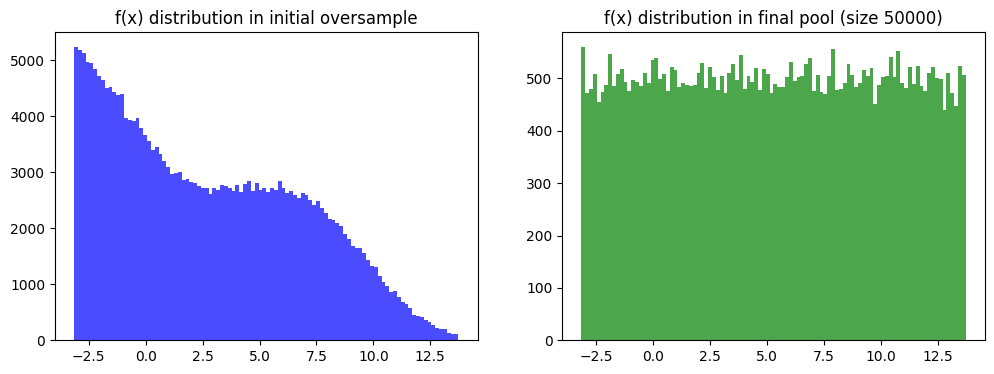

Starting Level-Set Transport model training...


Epoch [10/50], Avg Loss: 1.717801e+00, LR: 1.82e-03


Epoch [20/50], Avg Loss: 1.677813e+00, LR: 1.33e-03


Epoch 30/50:  14%|█▎        | 6/44 [00:01<00:06,  5.60it/s, loss=1.7135e+00, lr=7.55e-04] 

Collate Warning: OT computation or pair extraction failed: f_diff is not positive


Epoch [30/50], Avg Loss: 1.717316e+00, LR: 7.02e-04


Epoch [40/50], Avg Loss: 1.706548e+00, LR: 1.94e-04


Epoch [50/50], Avg Loss: 1.707488e+00, LR: 0.00e+00
Training finished or interrupted.
Running final visualization after training (will show plots)...


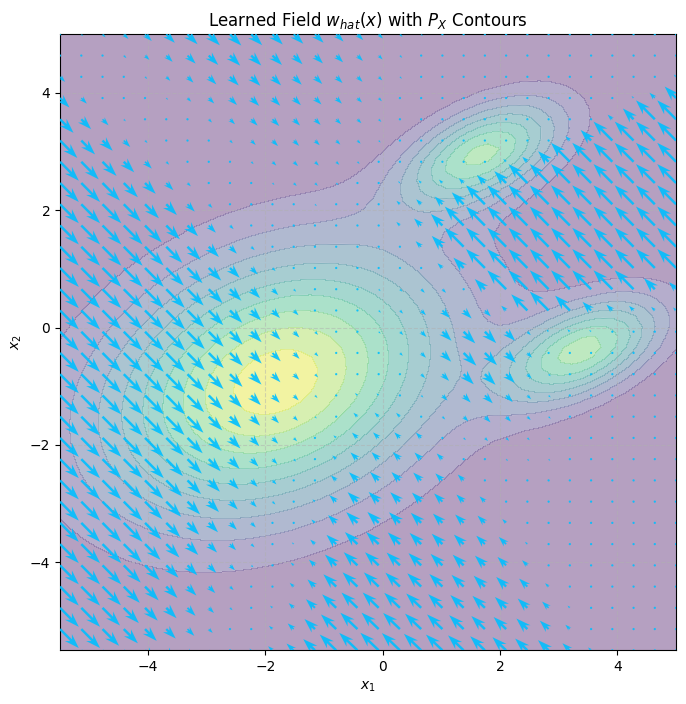

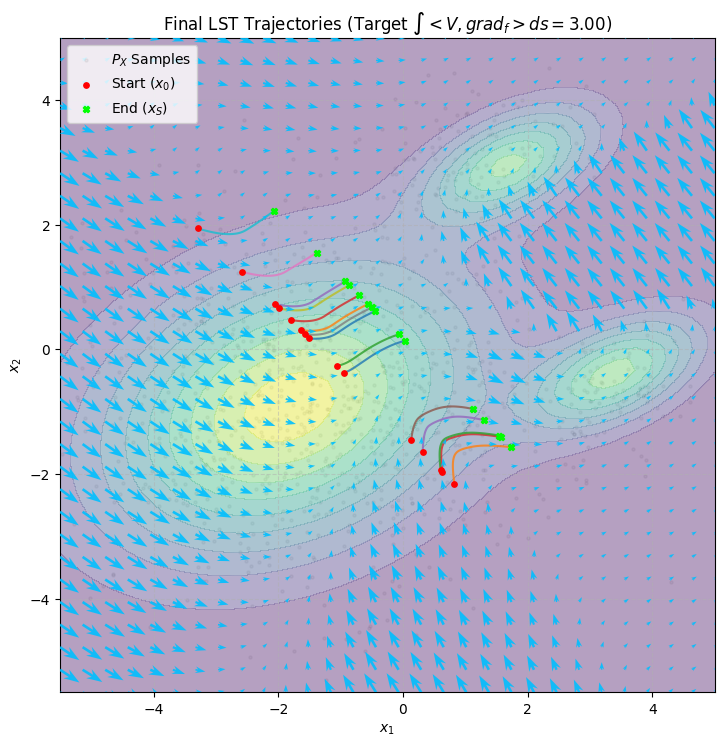

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchdiffeq import odeint
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from transformers import get_cosine_schedule_with_warmup


# --- Global Settings & Provided Functions ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps")
DTYPE = torch.float32
print(f"Using device: {DEVICE}, Dtype: {DTYPE}")

class HuberLoss(nn.Module):
    def __init__(self, delta=1.0, reduction='mean'):
        super().__init__()
        self.delta = delta
        if delta <= 0:
            raise ValueError("HuberLoss delta must be positive.")
        self.reduction = reduction

    def forward(self, predictions, targets):
        if predictions.shape != targets.shape:
            raise ValueError(f"Predictions shape {predictions.shape} must match targets shape {targets.shape}")
        targets = targets.to(dtype=predictions.dtype)
        error = torch.abs(targets - predictions)
        sum_error = (error**2).sum(dim=-1)
        quadratic_part_condition = (sum_error <= self.delta)
        linear_part_condition = ~quadratic_part_condition
        loss_values = torch.zeros(predictions.shape[0], dtype=predictions.dtype, device=predictions.device)
        loss_values[quadratic_part_condition] = 0.5 * sum_error[quadratic_part_condition]
        loss_values[linear_part_condition] = self.delta * (error[linear_part_condition].sum(dim=-1) - 0.5 * self.delta)
        if self.reduction == 'mean':
            return loss_values.mean()
        elif self.reduction == 'sum':
            return loss_values.sum()
        elif self.reduction == 'none':
            return loss_values
        else:
            raise ValueError(f"Invalid reduction: {self.reduction}")

huber = HuberLoss(1.)

# --- User Provided Plotting Helper ---
def _plot_current_rescaled_field_and_contours(
    model_V_hat, p_distribution, f_func, grad_f_func,
    ax, grid_extents, grid_points, device, dtype, stability_eps=1e-4
):
    # model_V_hat.eval() # Eval mode should be handled by the caller if necessary

    # 1. Plot p(x) contours
    contour_grid_points = grid_points * 2
    x_lin_dist = torch.linspace(grid_extents[0], grid_extents[1], contour_grid_points, device=device, dtype=dtype)
    y_lin_dist = torch.linspace(grid_extents[0], grid_extents[1], contour_grid_points, device=device, dtype=dtype)
    X_grid_dist, Y_grid_dist = torch.meshgrid(x_lin_dist, y_lin_dist, indexing='ij')
    grid_coords_dist = torch.stack([X_grid_dist.flatten(), Y_grid_dist.flatten()], dim=1)

    with torch.no_grad():
        log_probs = p_distribution.log_prob(grid_coords_dist)
        probs = torch.exp(log_probs).cpu().numpy().reshape(contour_grid_points, contour_grid_points)

    ax.contourf(X_grid_dist.cpu().numpy(), Y_grid_dist.cpu().numpy(), probs, levels=10, cmap='viridis', alpha=0.4)
    ax.contour(X_grid_dist.cpu().numpy(), Y_grid_dist.cpu().numpy(), probs, levels=10, colors='white', linewidths=0.5, alpha=0.3)

    # 2. Plot rescaled vector field V(x) (or w_hat(x) from model)
    x_lin_vf = torch.linspace(grid_extents[0], grid_extents[1], grid_points, device=device, dtype=dtype)
    y_lin_vf = torch.linspace(grid_extents[0], grid_extents[1], grid_points, device=device, dtype=dtype)
    X_grid_vf, Y_grid_vf = torch.meshgrid(x_lin_vf, y_lin_vf, indexing='ij')
    grid_coords_vf = torch.stack([X_grid_vf.flatten(), Y_grid_vf.flatten()], dim=1)

    with torch.no_grad():
        w_hat_x = model_V_hat(grid_coords_vf)*2 # Output of the model
        w_hat_norm_too_high = w_hat_x.norm(dim=-1, keepdim=True).clamp(min=3)
        w_hat_x = w_hat_x / w_hat_norm_too_high

    vf_np_x = w_hat_x[:, 0].cpu().numpy().reshape(grid_points, grid_points)
    vf_np_y = w_hat_x[:, 1].cpu().numpy().reshape(grid_points, grid_points)

    ax.quiver(X_grid_vf.cpu().numpy(), Y_grid_vf.cpu().numpy(), vf_np_x, vf_np_y,
              color='deepskyblue', scale=None, scale_units='xy', angles='xy',
              headwidth=4, headlength=6, width=0.004, zorder=5, alpha=0.9)
    # model_V_hat.train() # Train mode should be handled by the caller

# --- User Provided Final Visualization ---
def visualize_final_lst_flow(
    model_V_hat, p_distribution, f_func, grad_f_func,
    grid_extents, grid_points=30, num_trajectories=15,
    S_final=2.0, stability_eps=1e-4,
    writer=None, current_step=None, # For TensorBoard logging
    device=DEVICE, dtype=DTYPE     # Added device and dtype args
):
    # print("Starting detailed final LST flow visualization...")
    original_training_state = model_V_hat.training
    model_V_hat.eval()

    # Assuming model_V_hat might have this attribute, as per user's code
    if hasattr(model_V_hat, 'add_rating_gradient'):
        original_add_rating_gradient = model_V_hat.add_rating_gradient
        model_V_hat.add_rating_gradient = False

        # --- Plot 1: Learned Field w_hat(x) ---
        fig_field, ax_field = plt.subplots(1, 1, figsize=(8, 8))
        ax_field.set_xlabel("$x_1$"); ax_field.set_ylabel("$x_2$")
        ax_field.set_title("Learned Field $w_{hat}(x)$ with $P_X$ Contours")
        ax_field.set_aspect('equal', adjustable='box')
        ax_field.set_xlim(grid_extents); ax_field.set_ylim(grid_extents)
        ax_field.grid(True, linestyle='--', alpha=0.5)
        _plot_current_rescaled_field_and_contours(
            model_V_hat, p_distribution, f_func, grad_f_func, ax_field,
            grid_extents, grid_points, device, dtype, stability_eps
        )
        if writer and current_step is not None:
            writer.add_figure('visualization/learned_field_w_hat', fig_field, current_step)
            plt.close(fig_field)
        else:
            plt.show()

        model_V_hat.add_rating_gradient = True

    # --- Plot 2: Trajectories using V(x) ---
    # V(x) = w_hat(x) / (<w_hat(x), grad f(x)> + eps)
    def V_rescaled_field_func_for_ode(s_scalar, current_x_batch_ode): # s is not used by V(x) directly
        with torch.no_grad():
            w_hat_val = model_V_hat(current_x_batch_ode)
            grad_f_val = grad_f_func(current_x_batch_ode, f_func)
            dot_product = torch.sum(w_hat_val * grad_f_val, dim=1, keepdim=True)
            # Ensure epsilon adds constructively, prevent division by zero if dot_product is small positive
            # If dot_product is negative, V(x) points against f increase.
            denominator = dot_product + stability_eps * torch.sign(dot_product).clamp(min=0) + 1e-9
            return w_hat_val / denominator

    x_initial_trajectories = config['x_initial_trajectories']

    s_span = torch.linspace(0, S_final, 100, device=device, dtype=dtype)
    # print(f"Generating {num_trajectories} final trajectories (target integral of <V,grad_f> ds = {S_final:.2f})...")

    with torch.no_grad():
        trajectories = odeint(V_rescaled_field_func_for_ode, x_initial_trajectories, s_span, method='rk4', options=dict(step_size=S_final/100.0))

    trajectories_np = trajectories.permute(1, 0, 2).cpu().numpy() # (num_trajectories, num_timesteps, dim)

    fig_traj = plt.figure(figsize=(9, 8.5))
    ax_traj = fig_traj.gca()
    num_bg_samples = 1000
    bg_samples = p_distribution.sample((num_bg_samples,)).cpu().numpy()
    ax_traj.scatter(bg_samples[:, 0], bg_samples[:, 1], alpha=0.1, color='gray', label=f'$P_X$ Samples', s=5)
    _plot_current_rescaled_field_and_contours(
        model_V_hat, p_distribution, f_func, grad_f_func, ax_traj,
        grid_extents, grid_points, device, dtype, stability_eps
    )
    for i in range(num_trajectories):
        ax_traj.plot(trajectories_np[i, :, 0], trajectories_np[i, :, 1], '-', alpha=0.8, lw=1.5)
        ax_traj.scatter(trajectories_np[i, 0, 0], trajectories_np[i, 0, 1],
                     color='red', marker='o', s=15,
                     label='Start ($x_0$)' if i == 0 else None, zorder=5)
        ax_traj.scatter(trajectories_np[i, -1, 0], trajectories_np[i, -1, 1],
                     color='lime', marker='X', s=20,
                     label='End ($x_S$)' if i == 0 else None, zorder=5)

    ax_traj.set_title(f"Final LST Trajectories (Target $\int <V, grad_f> ds = {S_final:.2f}$)")
    ax_traj.set_xlabel("$x_1$"); ax_traj.set_ylabel("$x_2$")
    ax_traj.legend(loc='best'); ax_traj.set_xlim(grid_extents); ax_traj.set_ylim(grid_extents)
    ax_traj.set_aspect('equal', adjustable='box')
    ax_traj.grid(True, linestyle='--', alpha=0.5)

    if writer and current_step is not None:
        writer.add_figure('visualization/final_trajectories', fig_traj, current_step)
        plt.close(fig_traj)
    else:
        plt.show()

    if hasattr(model_V_hat, 'add_rating_gradient'):
        model_V_hat.add_rating_gradient = original_add_rating_gradient
    
    if original_training_state:
        model_V_hat.train()
    # print("Detailed final LST flow visualization finished.")


# --- Training Loop ---
def train_level_set_transport_model(p_distribution, f_func, grad_f_func, config, dataset): # Changed dataset to dataset_class
    print("Starting Level-Set Transport model training...")

    if isinstance(dataset, type):
        # Initialize Dataset
        train_dataset = dataset( # Use the passed class
            distribution=p_distribution,
            f_func=f_func,
            pool_size=config.get('dataset_pool_size', 30000),               # Configurable
            x1_batch_size=config.get('batch_size', 1024),        # Configurable
            min_f_diff=config.get('dataset_min_f_diff', 0.0001),             # Configurable
            min_norm_diff=config.get('dataset_min_norm_diff', 1e-10),        # Configurable
            device=DEVICE, dtype=DTYPE
        )
        dataloader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=0, drop_last=True)
    elif isinstance(dataset, tuple):    
        train_dataset, dataloader = dataset
    else:
        raise ValueError(f"Invalid dataset class: {type(dataset)}")
    from datetime import datetime
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    writer = SummaryWriter(log_dir=config.get('tensorboard_log_dir', f'runs/lst_experiment_{timestamp}'))


    model_V_hat = VectorFieldModel2( # Make sure this matches your class structure
        f_module(f_func),            # Pass f_module instance if needed by your model
        input_dim=3,                 # Assuming model takes 2D xt input
        hidden_dims=[config.get('model_hidden_dim', 512)] * 4,
        output_dim=2,
        activation=torch.nn.ReLU(),
        dropout_rate=0.1,
        add_rating_gradient=False, # If your model uses this attribute
    ).to(DEVICE, DTYPE)

    optimizer = optim.AdamW(model_V_hat.parameters(), lr=config['lr'], weight_decay=0.001)

    # Plotting setup (loss curve and one dynamic vector field plot)
    # fig_dynamic will contain ax_loss and ax_vf
    fig_dynamic, (ax_loss, ax_vf) = plt.subplots(2, 1, figsize=(8, 13), gridspec_kw={'height_ratios': [1, 2]})
    plt.subplots_adjust(hspace=0.35)
    losses_history = []
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel(f"{config.get('loss_fn', 'Huber')} Loss")
    ax_loss.set_title(f"Training Loss")
    ax_loss.grid(True)
    line_loss, = ax_loss.plot([], [], 'b-')
    # ax_vf setup will happen before each plot
    plt.ioff() # Turn off interactive plotting for the main training figure to avoid multiple windows

    global_optimizer_steps = 0
    total_training_steps = config['num_epochs'] * len(dataloader)
    warmup_steps = config.get('warmup_steps', int(0.1 * total_training_steps))  # Default to 10% of total steps
    
    scheduler = get_cosine_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_training_steps
    )



    ys = f_func(train_dataset[:100][0].to(DEVICE, DTYPE))
    min_y, max_y, delta_y = ys.min(), ys.max(), ys.max()-ys.min()
    config['vis_S_final'] = delta_y*0.8
    config['vis_trajectory_levelset'] = min_y+delta_y*0.01

    num_initial_points_sample = 500
    initial_points_candidate = p_distribution.sample((num_initial_points_sample*1000,)).to(DEVICE, DTYPE)
    y_pred = (f_func(initial_points_candidate) - config.get('vis_trajectory_levelset',0))**2
    sort_indices = torch.argsort(y_pred.view(-1))
    initial_points_candidate = initial_points_candidate[sort_indices[:num_initial_points_sample]]
    selected_indices = torch.randperm(num_initial_points_sample, device=DEVICE)[:config['vis_num_trajectories_final']]
    config['x_initial_trajectories'] = initial_points_candidate[selected_indices]

    try:
        for epoch in range(config['num_epochs']):
            epoch_loss_sum = 0.0
            num_optimizer_steps_in_epoch = 0
            model_V_hat.train()
            data_iterator = tqdm(dataloader, desc=f"Epoch {epoch+1}/{config['num_epochs']}", leave=False)

            for i, (x0_batch, x1_batch, _) in enumerate(data_iterator): # u_hat_target_from_dataset not directly used for loss target here
                if not x0_batch.numel(): continue

                x0_batch = x0_batch.to(DEVICE, DTYPE)
                x1_batch = x1_batch.to(DEVICE, DTYPE)

                optimizer.zero_grad()
                t_batch = torch.rand(x0_batch.shape[0]*8, 1).to(DEVICE, DTYPE)#*0.8 + 0.1
                nstack = lambda x: torch.cat([x]*8, dim=0)
                x0_batch = nstack(x0_batch)
                x1_batch = nstack(x1_batch)
                xt_batch = (1 - t_batch) * x0_batch + t_batch * x1_batch
                xt_batch = xt_batch.view(-1, 2)

                # Calculate target for w_hat(xt)
                sigma_t_batch = x1_batch - x0_batch # Vector from x0 to x1
                grad_f_xt = grad_f_func(xt_batch, f_func)
                norm_grad_f_xt = torch.linalg.norm(grad_f_xt, dim=-1, keepdim=True) + 1e-9
                normalized_grad_f_xt = grad_f_xt / norm_grad_f_xt
                
                # Target is component of sigma_t_batch orthogonal to normalized_grad_f_xt
                w_hat_target_batch = sigma_t_batch - torch.sum(sigma_t_batch * normalized_grad_f_xt, dim=-1, keepdim=True) * normalized_grad_f_xt

                w_hat_pred_batch = model_V_hat(xt_batch) # Assuming model takes 2D xt
                loss = huber(w_hat_pred_batch, w_hat_target_batch)
                loss.backward()

                total_grad_norm = 0.0
                for p in model_V_hat.parameters():
                    if p.grad is not None: total_grad_norm += p.grad.data.norm(2).item() ** 2
                total_grad_norm = total_grad_norm ** 0.5
                writer.add_scalar('train/grad_norm', total_grad_norm, global_optimizer_steps)
                optimizer.step()
                scheduler.step()
                writer.add_scalar('train/batch_loss', loss.item(), global_optimizer_steps)
                writer.add_scalar('train/learning_rate', optimizer.param_groups[0]['lr'], global_optimizer_steps)
                with torch.no_grad():
                    writer.add_scalar('train_details/w_hat_target_norm_mean', w_hat_target_batch.norm(dim=-1).mean().item(), global_optimizer_steps)
                    writer.add_scalar('train_details/w_hat_pred_norm_mean', w_hat_pred_batch.norm(dim=-1).mean().item(), global_optimizer_steps)

                epoch_loss_sum += loss.item()
                num_optimizer_steps_in_epoch += 1
                global_optimizer_steps += 1
                data_iterator.set_postfix(loss=f"{loss.item():.4e}", lr=f"{optimizer.param_groups[0]['lr']:.2e}")
            
            avg_epoch_loss = epoch_loss_sum / num_optimizer_steps_in_epoch if num_optimizer_steps_in_epoch > 0 else 0.0
            losses_history.append(avg_epoch_loss)
            writer.add_scalar('train/epoch_loss', avg_epoch_loss, epoch)

            for name, param in model_V_hat.named_parameters():
                writer.add_histogram(f'model_weights/{name}', param.data, epoch)
                if param.grad is not None: writer.add_histogram(f'model_grads/{name}', param.grad.data, epoch)

            if (epoch + 1) % config.get('print_loss_every_epochs', 1) == 0:
                print(f"Epoch [{epoch+1}/{config['num_epochs']}], Avg Loss: {avg_epoch_loss:.6e}, LR: {optimizer.param_groups[0]['lr']:.2e}")

            # Update and log the combined (loss + vector field) plot to TensorBoard
            if (epoch + 1) % config.get('plot_field_every_epochs', 5) == 0 or epoch == config['num_epochs'] - 1:
                model_V_hat.eval() # Set model to evaluation mode for plotting
                # Update loss curve part of fig_dynamic
                line_loss.set_data(range(1, len(losses_history) + 1), losses_history)
                ax_loss.relim(); ax_loss.autoscale_view(tight=True)

                # Update vector field part (ax_vf) of fig_dynamic
                ax_vf.clear()
                ax_vf.set_xlabel("$x_1$"); ax_vf.set_ylabel("$x_2$")
                ax_vf.set_title(f"Learned Field $w_{{hat}}(x)$ (Epoch {epoch+1})")
                ax_vf.set_aspect('equal', adjustable='box')
                ax_vf.set_xlim(config['vis_grid_extents']); ax_vf.set_ylim(config['vis_grid_extents'])
                ax_vf.grid(True, linestyle='--', alpha=0.5)
                _plot_current_rescaled_field_and_contours(
                    model_V_hat, p_distribution, f_func, grad_f_func, ax_vf,
                    config['vis_grid_extents'], config.get('vis_grid_points_dynamic', 15),
                    DEVICE, DTYPE, config.get('rescaling_stability_eps', 1e-4)
                )
                writer.add_figure('training/loss_and_vector_field', fig_dynamic, epoch)
                model_V_hat.train() # Set model back to training mode

                # Optionally, run the detailed visualization and log its plots to TensorBoard
                if config.get('run_visualize_final_lst_flow_during_train', True):
                    visualize_final_lst_flow(
                        model_V_hat, p_distribution, f_func, grad_f_func,
                        grid_extents=config['vis_grid_extents'],
                        grid_points=config.get('vis_grid_points_final', 25),
                        num_trajectories=config.get('vis_num_trajectories_final', 10),
                        S_final=config.get('vis_S_final', 2.0),
                        stability_eps=config.get('rescaling_stability_eps', 1e-4),
                        writer=writer, current_step=epoch, # Pass writer and epoch
                        device=DEVICE, dtype=DTYPE
                    )
            writer.flush() 
    except KeyboardInterrupt:
        print("Training interrupted by user.")
    finally:
        writer.close()
        plt.close(fig_dynamic) # Close the main training plot figure
        print("Training finished or interrupted.")
    return model_V_hat


# --- Define p(x), f(x) and grad_f(x) (from user's script) ---
mix_probs = torch.tensor([0.8, 0.1,0.1]).to(DEVICE, DTYPE)
means = torch.tensor([[-1.5, -1.5], [2, -.2], [-.2,2]]).to(DEVICE, DTYPE)+0.5
std_devs = torch.tensor([0.7, 0.3, 0.3]).to(DEVICE, DTYPE)*1.9
cov_mats_list = []
for std in std_devs:
    cov_mats_list.append(torch.eye(2).to(DEVICE, DTYPE) * (std**2) + torch.tensor([[0.0, (std*0.4)*2/3], [(std*0.4)*2/3, -np.random.random()* (std**2)/10]]).to(DEVICE, DTYPE))
cov_mats = torch.stack(cov_mats_list)
p_dist_param_device = DEVICE
mix = torch.distributions.Categorical(mix_probs.to(p_dist_param_device))
comp = torch.distributions.MultivariateNormal(means.to(p_dist_param_device), cov_mats.to(p_dist_param_device))
p_distribution_base = torch.distributions.MixtureSameFamily(mix, comp)

class SkewedDistribution(torch.distributions.Distribution):
    arg_constraints = {}
    has_rsample = False
    def __init__(self, base_distribution, device=DEVICE, dtype=DTYPE): # Added defaults
        self.base_distribution = base_distribution
        self.device = device
        self.dtype = dtype
        super().__init__(batch_shape=base_distribution.batch_shape, event_shape=base_distribution.event_shape)

    def log_prob(self, coords_tensor):
        skewed_coords = coords_tensor + (coords_tensor @ torch.tensor([[1.],[1.]], device=self.device, dtype=self.dtype)) * torch.tensor([[-.3,.3]], device=self.device, dtype=self.dtype)
        return self.base_distribution.log_prob(skewed_coords/torch.tensor([[1.,1.75]], device=self.device, dtype=self.dtype))

    def sample(self, sample_shape=torch.Size()):
        base_samples = self.base_distribution.sample(sample_shape)
        coords = base_samples.clone()
        for _ in range(3):
            skew_term = (coords @ torch.tensor([[1.],[1.]], device=self.device, dtype=self.dtype)) * torch.tensor([[-.3,.3]], device=self.device, dtype=self.dtype)
            skewed_coords = coords + skew_term
            correction = base_samples - skewed_coords
            coords = coords + 0.5 * correction
        return coords*torch.tensor([[1.,1.75]], device=self.device, dtype=self.dtype)

skewed_distribution = SkewedDistribution(p_distribution_base, device=DEVICE, dtype=DTYPE)

def f_potential_func(coords_tensor): # coords_tensor is (N, 2)
    return torch.sum(coords_tensor, dim=-1)*2 + torch.sum(coords_tensor**2, dim=-1) / 300.0

def kinked_potential_function(coords_tensor, base_slope=1.0, kink_strength=0.5, kink_hardness=2.0):
    """
    Args:
        coords_tensor (torch.Tensor): A tensor of shape (N, 2) representing (x, y) coordinates.
        base_slope (float): The baseline slope for the (x+y) component.
                            The original f(x,y)=x+y corresponds to base_slope=1, kink_strength=0.
        kink_strength (float): Determines the magnitude of the slope variation.
                               The slope factor will range roughly from
                               (base_slope - kink_strength) to (base_slope + kink_strength).
                               Should be positive. To ensure slope factor remains positive,
                               keep base_slope > kink_strength if that's desired.
        kink_hardness (float): Controls the sharpness of the "kink" (transition)
                               around the line y = x. Higher values mean a sharper transition."""
    if not isinstance(coords_tensor, torch.Tensor):
        raise TypeError("coords_tensor must be a PyTorch tensor.")
    if coords_tensor.ndim != 2 or coords_tensor.shape[-1] != 2:
        raise ValueError("coords_tensor must have shape (N, 2).")
    if not (isinstance(base_slope, (int, float)) and
            isinstance(kink_strength, (int, float)) and
            isinstance(kink_hardness, (int, float))):
        raise TypeError("base_slope, kink_strength, and kink_hardness must be numbers.")
    if kink_strength < 0:
        # Warning or error, as negative strength inverts the intended effect
        print("Warning: kink_strength is negative. The effect on level set spacing might be inverted.")


    x = coords_tensor[:, 0]
    y = coords_tensor[:, 1]

    x_plus_y = x + y
    y_minus_x = y - x

    # Scaling factor that depends on (y - x)
    # tanh ranges from -1 to 1.
    # So, scaling_factor ranges from (base_slope - kink_strength) to (base_slope + kink_strength)
    scaling_factor = base_slope + kink_strength * torch.tanh(kink_hardness * y_minus_x)

    output_potential = scaling_factor * x_plus_y

    return output_potential + torch.sum(coords_tensor**2, dim=-1) / 300.0
@torch.enable_grad()
def grad_f_function(x_coords, f_func_ref=f_potential_func):
    temp_x = x_coords.detach().clone().requires_grad_(True)
    f_values = f_func_ref(temp_x)
    grad_outputs_tensor = torch.ones_like(f_values, device=f_values.device, dtype=f_values.dtype)
    gradients = torch.autograd.grad(
        outputs=f_values, inputs=temp_x, grad_outputs=grad_outputs_tensor,
        create_graph=False, retain_graph=False, allow_unused=False
    )[0]
    return gradients

# --- Main Execution (Example) ---
if __name__ == "__main__":
    # Ensure f_module and VectorFieldModel2 are defined here or in a previous cell
    # For this example, let's include simple placeholders if they weren't defined earlier
    # In your notebook, these would already be defined.
    class f_module(torch.nn.Module):
        def __init__(self, f_potential_func_ref):
            super(f_module, self).__init__()
            self.f_potential_func = f_potential_func_ref
        def forward(self, x):
            return self.f_potential_func(x)


    shared_vis_grid_extents = (-5.5, 5.0)
    config = {
        'dataset_pool_size': 50000,        
        'dataset_min_f_diff': 0.001,
        'dataset_min_norm_diff': 1e-4,

        'batch_size': 512, # Actual training batch size of (x0,x1,u) triples
        'num_epochs': 50,
        'lr': 2e-3, # Adjusted learning rate
        'warmup_steps': 20, # Warmup over these many optimizer steps
        'warmup_initial_lr': 1e-6,

        'model_hidden_dim': 512, # Reduced for faster example
        'print_loss_every_epochs': 10,
        'plot_field_every_epochs': 1, # Log combined plot to TB
        'run_visualize_final_lst_flow_during_train': True, # Log detailed plots to TB

        'vis_grid_extents': shared_vis_grid_extents,
        'vis_grid_points_dynamic': 50, # For ax_vf plot
        'vis_grid_points_final': 32,   # For visualize_final_lst_flow
        'vis_num_trajectories_final': 75,
        'vis_trajectory_levelset': 0.0,
        'vis_S_final': 2.0,
        'rescaling_stability_eps': 1e-3,
        # 'tensorboard_log_dir': 'runs/lst_experiment_main',
        'tensorboard_hist_freq': 100, # Log histograms to TB every N steps
    }

    # To run in Jupyter:
    # %load_ext tensorboard
    # %tensorboard --logdir runs/lst_experiment_main --reload_interval 5


    pool_dataset = PoolDataset(
        skewed_distribution, 
        f_potential_func, 
        pool_size=config['dataset_pool_size'],
        device=DEVICE, # Store pool data on the main training device
        dtype=DTYPE
    )
    train_dataloader = DataLoader(
        pool_dataset,
        batch_size=config['batch_size'] * 2 +int(config['batch_size'] * .1)*2,
        shuffle=True, # Shuffles indices from PoolDataset before fetching
        collate_fn=custom_collate,
        num_workers=0, # Start with 0 workers for simplicity, then increase if I/O bound
        drop_last=True # Ensures collate_fn always gets an even number of samples if dataloader_batch_size is even
    )

    trained_V_hat_model = train_level_set_transport_model(
        skewed_distribution, f_potential_func, grad_f_function,
        config,
        (pool_dataset, train_dataloader) 
    )

    if trained_V_hat_model:
        print("Running final visualization after training (will show plots)...")
        # This call will show plots as it's outside the training loop's TB logging context
        # unless we pass a new writer or handle it differently.
        # For now, let it show plots directly.
        visualize_final_lst_flow(
            trained_V_hat_model,
            skewed_distribution,
            f_potential_func, grad_f_function,
            grid_extents=shared_vis_grid_extents,
            grid_points=30,
            num_trajectories=15,
            S_final=3.0,
            stability_eps=config['rescaling_stability_eps'],
            device=DEVICE, dtype=DTYPE
        )
        # To save the final model:
        # torch.save(trained_V_hat_model.state_dict(), "trained_lst_model.pth")


## Results

TensorBoard SummaryWriter initialized. Logging to: runs/lst_experiment_main
